## Import des données et pré-traitement

In [1]:
import pandas as pd
from src.utility.descriptive_statistics import descriptive_statistics

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-01')]

for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,index,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
0,1988-01-04,187.50,193.50,198.25,200.00,202.75
1,1988-01-05,187.50,193.25,197.25,198.25,200.75
2,1988-01-06,191.00,195.75,199.75,201.75,204.50
3,1988-01-07,192.75,198.75,202.75,204.50,208.50
4,1988-01-08,192.50,198.00,202.00,203.50,207.25
...,...,...,...,...,...,...
7288,2016-12-23,345.75,352.50,360.00,367.25,376.25
7289,2016-12-27,355.00,361.25,368.50,375.75,384.25
7290,2016-12-28,348.25,354.75,362.00,369.25,378.25
7291,2016-12-29,349.75,355.75,363.00,370.25,379.25


## Statistiques descriptives

In [2]:
import numpy as np

original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
df_combined_stats

,Prices (c/bu),Log returns
Mean,328.0151,0.0001
Median,269.1875,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,143.9133,0.0172
Skewness,1.53,-1.04
Kurtosis,1.57,19.59
Autocorrelation,0.999,0.05
ADF test p-value (10 lags),0.16,0.0
Nb obs,7312,7311


## Graphiques


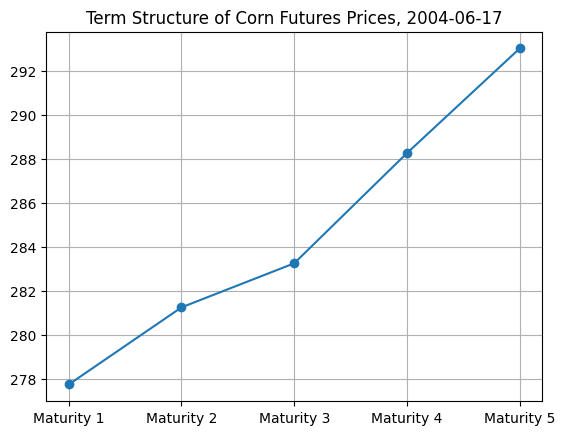

In [3]:
import matplotlib.pyplot as plt
import os 

df.set_index('index', inplace=True)

target_date = '2004-06-17'

prix_17_06_2004 = df.loc[target_date, ['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5']]

plt.plot(['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5'], prix_17_06_2004 , marker='o', linestyle='-')
plt.title(f'Term Structure of Corn Futures Prices, {target_date}')
plt.grid()

output_dir = 'static/graph'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f'term_structure_{target_date}.png')
plt.savefig(output_path)
plt.show()


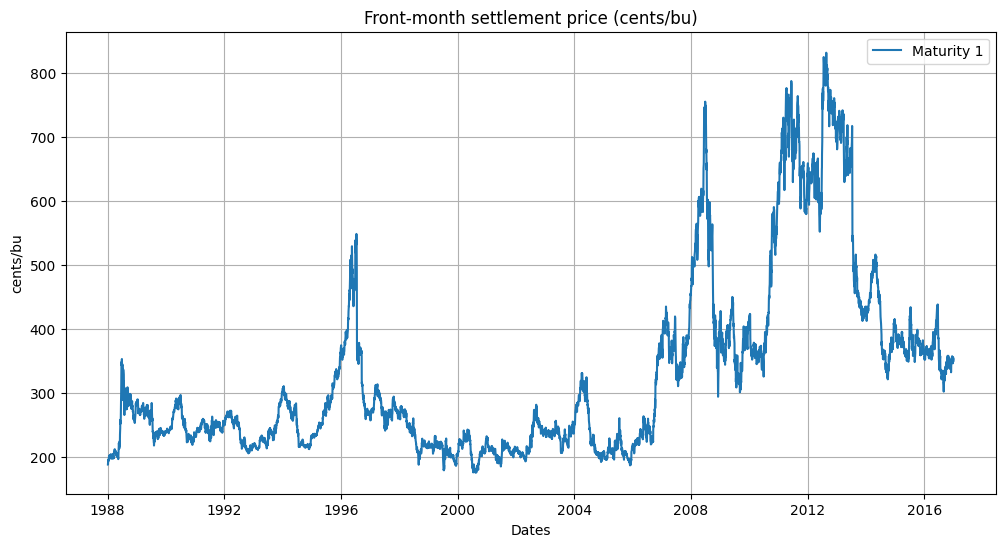

Graph saved to static/graph\price_history.png


In [4]:
from src.graph.graph import plot_and_save_graph

plot_and_save_graph(df, ["Maturity 1"], 
                    "Front-month settlement price (cents/bu)", 
                    "Dates", "cents/bu", 
                    output_filename='price_history.png', 
                    output_dir='static/graph')

# Estimation du modele espace d'etat


## Preparation des données

In [5]:
import pandas as pd
import numpy as np
from src.utility.date import get_T, get_t

df.index = pd.to_datetime(df.index)
df[['T1', 'T2', 'T3', 'T4', 'T5']] = pd.DataFrame(df.index.map(lambda x: pd.Series(get_T(x))).tolist(), index=df.index)
for i in range(1, 6):
    df[f'Maturity {i}'] = np.log(df[f'Maturity {i}'])
df
df = df[(df.index >= '1988-02-01') & (df.index <= '2015-01-01')]

#reference_date = df.index[0]
#df['t'] = (df.index - reference_date).days / 365.25

df['t'] = df.index.to_series().apply(get_t)
df

C:\Users\cypri\AppData\Local\Temp\ipykernel_12480\2894162335.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t'] = df.index.to_series().apply(get_t)


,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,T1,T2,T3,T4,T5,t
index,,,,,,,,,,,
1988-02-01,5.287004,5.316894,5.331510,5.339939,5.349486,0.117808,0.284932,0.452055,0.619178,0.871233,0.084932
1988-02-02,5.289529,5.316894,5.331510,5.335131,5.345916,0.115068,0.282192,0.449315,0.616438,0.868493,0.087671
1988-02-03,5.292048,5.318120,5.333926,5.338739,5.353042,0.112329,0.279452,0.446575,0.613699,0.865753,0.090411
1988-02-04,5.311974,5.336335,5.350673,5.358942,5.375278,0.109589,0.276712,0.443836,0.610959,0.863014,0.093151
1988-02-05,5.304548,5.332719,5.349486,5.356586,5.367144,0.106849,0.273973,0.441096,0.608219,0.860274,0.095890
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,6.010654,6.031286,6.047372,6.055026,6.069004,0.221918,0.389041,0.556164,0.723288,0.975342,0.978082
2014-12-26,6.027676,6.047372,6.063204,6.069582,6.084499,0.216438,0.383562,0.550685,0.717808,0.969863,0.983562
2014-12-29,6.022842,6.043226,6.059123,6.065528,6.079361,0.208219,0.375342,0.542466,0.709589,0.961644,0.991781


## Estimation du modèle espace d'Etat

In [6]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
from tqdm import tqdm
from src.model.kalman import KalmanModel
from src.utility.parameter import calculate_num_parameters
from src.utility.parameter import mu, kappa, sigma1, sigma2, rho, lambdaz
from denoised_price import denoise_all_signal, plot_comparaison

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

def objective(params, observations, times, maturities, n_factors):
    """Objective function for Kalman Model optimization."""
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    num_params = calculate_num_parameters(n_factors)
    model_params = {
        key: params[i] for i, key in enumerate(param_keys[:num_params])
    }
    model_params['maturities'] = maturities
    model_params['current_time'] = times

    model = KalmanModel(n_factors=n_factors, params=model_params)
    return model.compute_likelihood(observations, times, maturities)

df.index = pd.to_datetime(df.index)
reference_date = df.index[0]

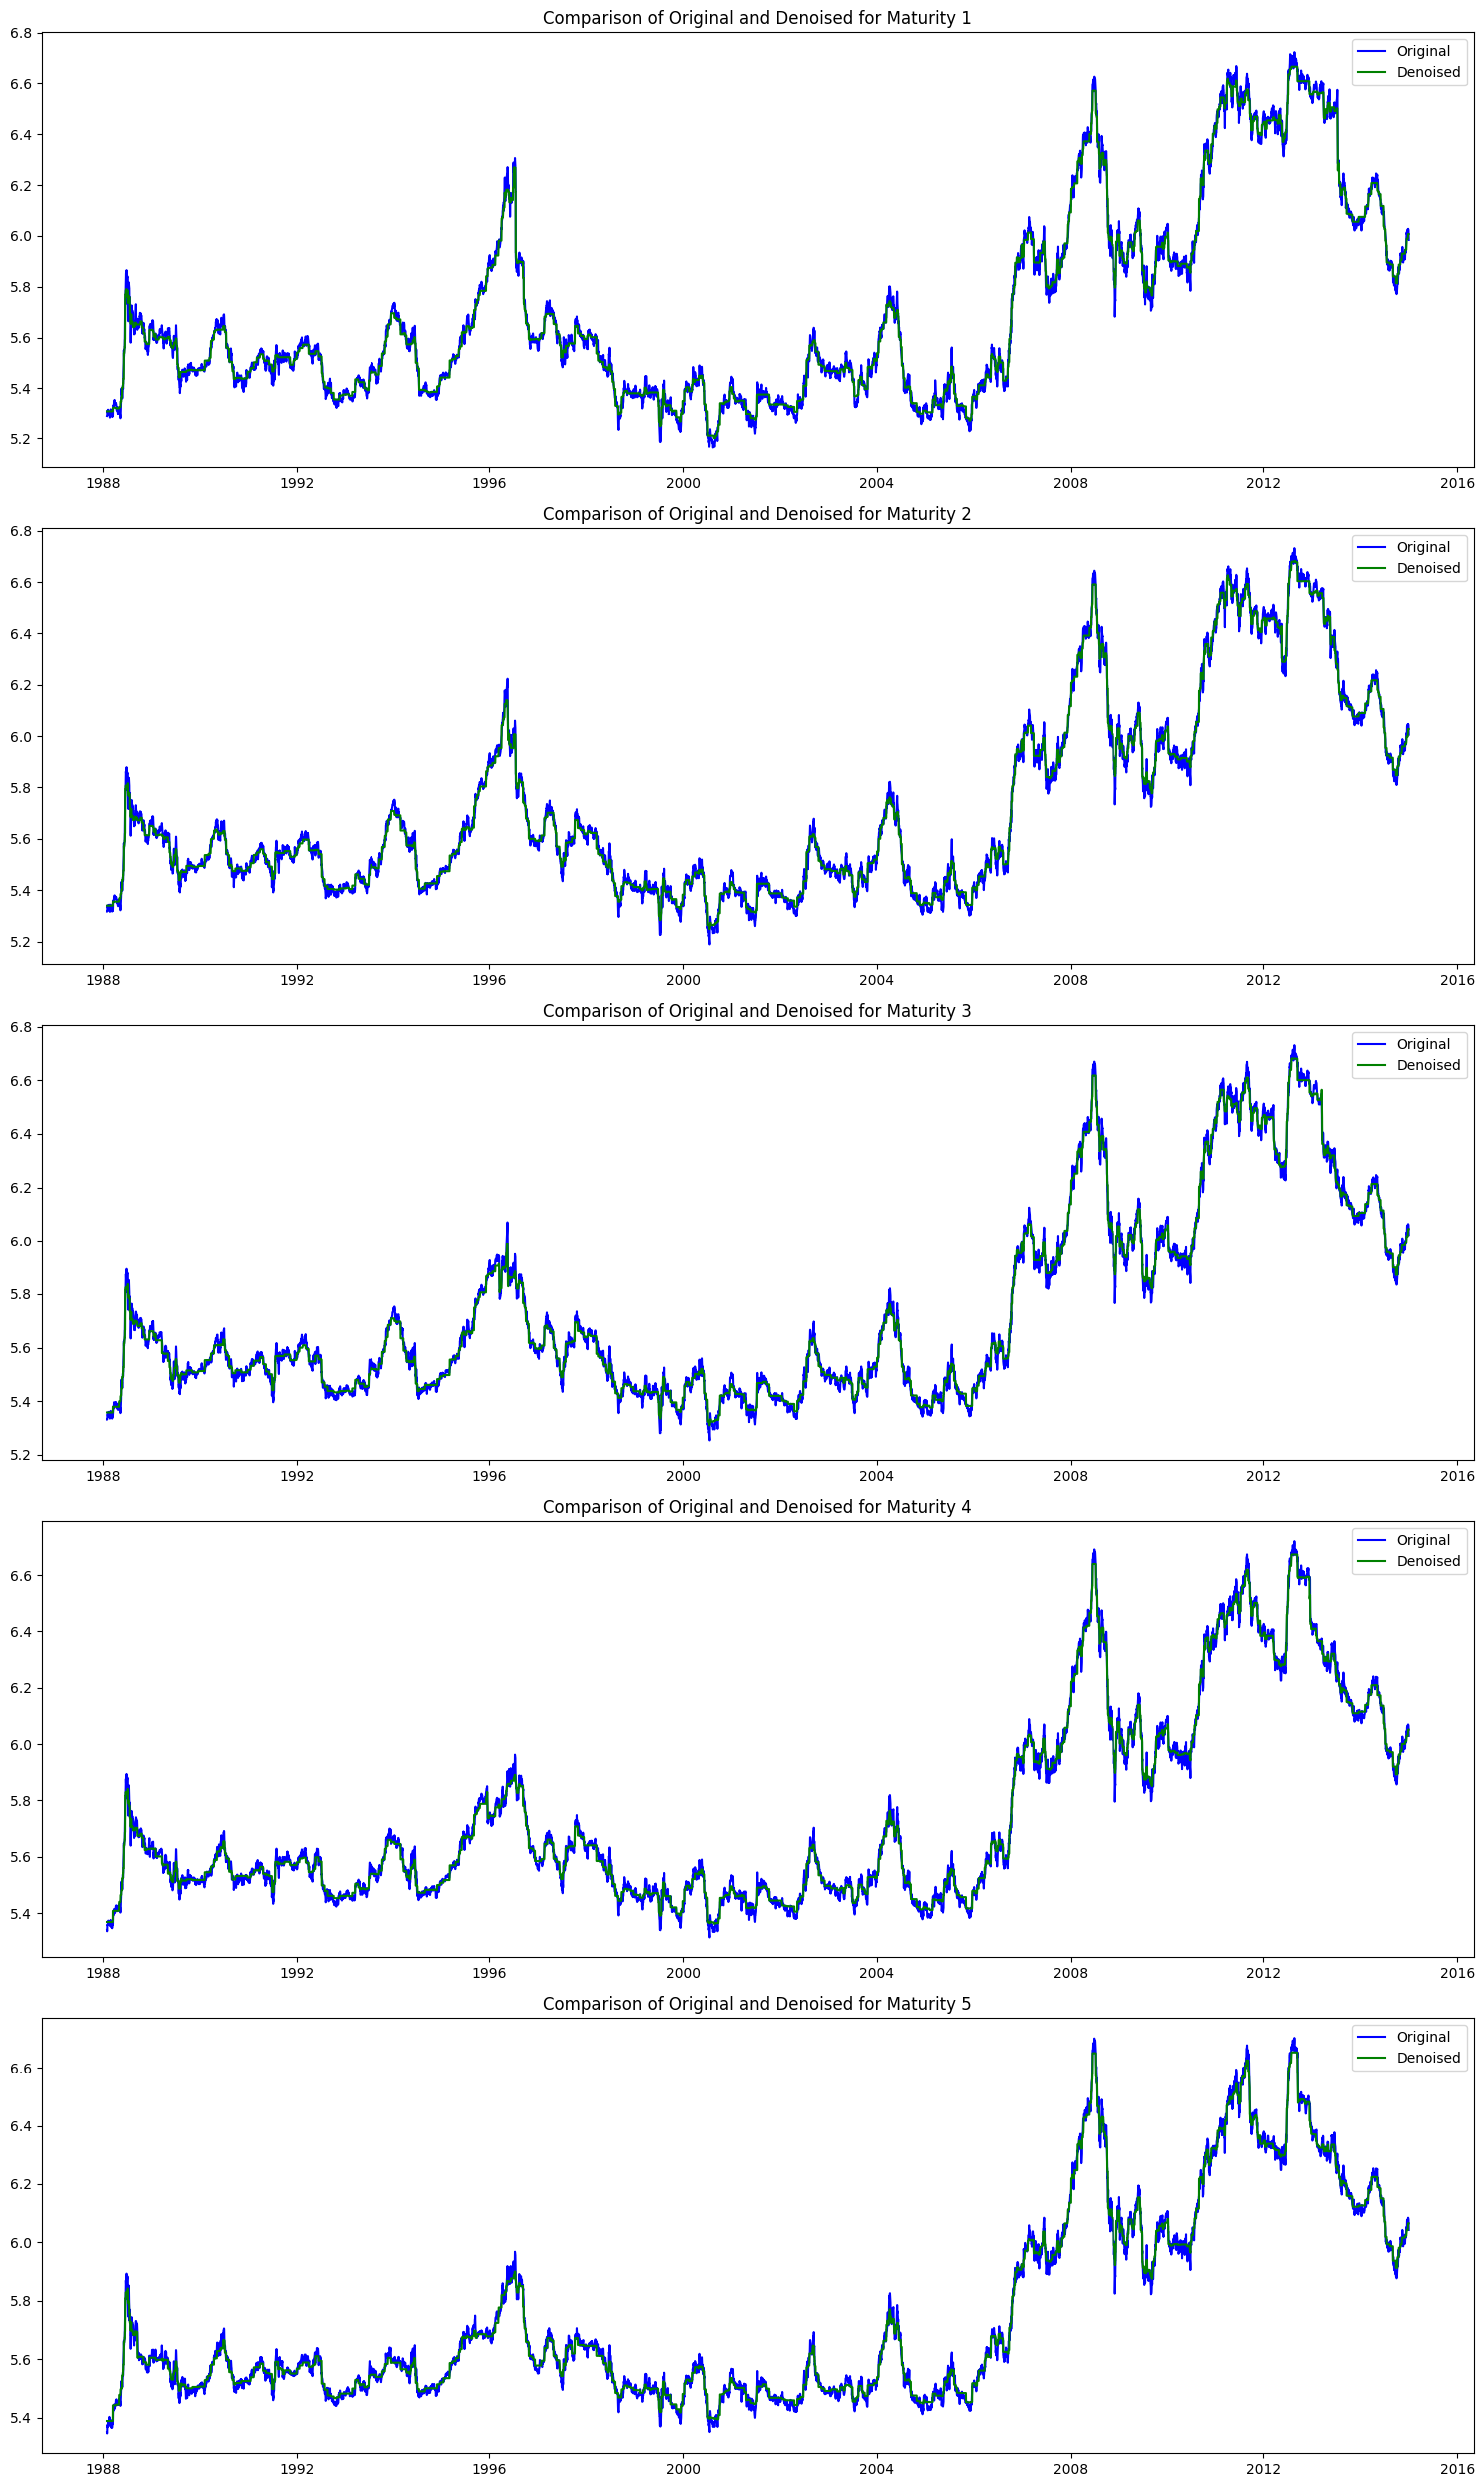

In [7]:
#denoised series
bool_denoised = True
if bool_denoised:
    df_price = df.iloc[:, 0:5]
    denoised_price_df = denoise_all_signal(df_price, wavelet = 'db1', level = 1)
    plot_comparaison(df_price,denoised_price_df)

In [9]:
if bool_denoised:
    observations = denoised_price_df.values
else:    
    observations = df.iloc[:, 0:5].values

maturities = df.iloc[:, 6:11].values
times = df['t'].values

initial_guesses = {
    1: [mu, sigma1, lambdaz],
    2: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho],
    3: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho],
    4: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho, kappa, sigma2, lambdaz, rho, rho, rho]
}

results = {}
for n_factors in tqdm(range(1, 5)):

    initial_result = minimize(
        objective,
        initial_guesses[n_factors],
        args=(observations, times, maturities, n_factors),
        method='Nelder-Mead',
        options={'maxiter': 50}
    )
    

    final_result = minimize(
        objective,
        initial_result.x,
        args=(observations, times, maturities, n_factors),
        method='BFGS',
        options={'maxiter': 3, 'disp': True}
    )
    
    results[n_factors] = final_result
    print(f"Optimized parameters for {n_factors} factors:", final_result.x)

    hessian_inv = final_result.hess_inv
    if isinstance(hessian_inv, np.ndarray):
        covariance_matrix = hessian_inv
    else:
        covariance_matrix = hessian_inv.todense()

    std_errors = np.sqrt(np.diag(covariance_matrix))

    z_values = final_result.x / std_errors
    p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_values]

    num_params = calculate_num_parameters(n_factors)
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    param_keys = param_keys[:num_params]

    for i, (param, std_err, p_value) in enumerate(zip(final_result.x, std_errors, p_values)):
        print(f"Parameter {param_keys[i]}: estimate={param}, std_error={std_err}, p_value={p_value}")


 25%|██▌       | 1/4 [09:51<29:34, 591.48s/it]

         Current function value: -42685.247158
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimized parameters for 1 factors: [0.04239032 0.1454978  0.02315529]
Parameter mu: estimate=0.042390319720439565, std_error=0.002370441434205009, p_value=0.0
Parameter sigma1: estimate=0.14549780004689078, std_error=0.015880811603752463, p_value=0.0
Parameter lambda1: estimate=0.023155290469284346, std_error=0.0017829997761706648, p_value=0.0


 50%|█████     | 2/4 [17:14<16:48, 504.20s/it]

         Current function value: -42656.617046
         Iterations: 3
         Function evaluations: 40
         Gradient evaluations: 5
Optimized parameters for 2 factors: [ 0.08326114  0.223178   -0.05850507  0.04126868  0.20309359  0.00928096
 -0.66345314]
Parameter mu: estimate=0.08326114239488368, std_error=0.8350567682505875, p_value=0.9205768125979013
Parameter sigma1: estimate=0.22317799899101923, std_error=0.6390624942072433, p_value=0.7269187551324916
Parameter lambda1: estimate=-0.05850506832511053, std_error=0.6599256795934669, p_value=0.9293568705767379
Parameter kappa2: estimate=0.04126868115646558, std_error=0.8319076296260365, p_value=0.9604353390071809
Parameter sigma2: estimate=0.2030935924387398, std_error=1.0845473271578496, p_value=0.851455872732205
Parameter lambda2: estimate=0.009280963449748172, std_error=0.389755645023024, p_value=0.9810023593368762
Parameter rho12: estimate=-0.6634531434933121, std_error=0.957758153023497, p_value=0.4884886174395455


 75%|███████▌  | 3/4 [25:25<08:18, 498.15s/it]

         Current function value: -41694.996307
         Iterations: 3
         Function evaluations: 78
         Gradient evaluations: 6
Optimized parameters for 3 factors: [ 0.23249052  0.29487262 -0.08968179  0.95754997  0.31834681 -0.01867016
 -0.34994691  0.56319826  0.25006249  0.00532663 -0.40152007 -0.30585086]
Parameter mu: estimate=0.23249051568612936, std_error=0.41020741510490455, p_value=0.5708749956072383
Parameter sigma1: estimate=0.2948726224764783, std_error=1.0393586813992046, p_value=0.7766354540897953
Parameter lambda1: estimate=-0.08968178753529749, std_error=0.8915627406659438, p_value=0.9198763881022265
Parameter kappa2: estimate=0.9575499651526211, std_error=0.9979182679930966, p_value=0.3372830096430057
Parameter sigma2: estimate=0.3183468128249973, std_error=1.2284125239174877, p_value=0.7955171792645512
Parameter lambda2: estimate=-0.018670155852371372, std_error=0.4708931091303887, p_value=0.9683734443574468
Parameter rho12: estimate=-0.34994691164473796, std

100%|██████████| 4/4 [35:20<00:00, 530.20s/it]

         Current function value: -41191.740205
         Iterations: 3
         Function evaluations: 133
         Gradient evaluations: 7
Optimized parameters for 4 factors: [ 0.20307342  0.38440737 -0.10378561  0.74411018  0.2544488  -0.06373304
 -0.28069164  0.72637541  0.24034523 -0.04434648 -0.32014603 -0.28385163
  0.73642964  0.23960347 -0.02099584 -0.28404716 -0.28089552 -0.28508532]
Parameter mu: estimate=0.20307342436164538, std_error=0.9145654261915377, p_value=0.8242799214737035
Parameter sigma1: estimate=0.38440736723577196, std_error=0.5942582606268236, p_value=0.5177165994288075
Parameter lambda1: estimate=-0.10378560986765524, std_error=0.9389484644690548, p_value=0.9119859880623349
Parameter kappa2: estimate=0.7441101776584857, std_error=1.0025872712591477, p_value=0.4579722683205698
Parameter sigma2: estimate=0.25444880052964425, std_error=1.0168356315522113, p_value=0.8024049079391038
Parameter lambda2: estimate=-0.0637330435458112, std_error=0.5785883806038791, p_val